Models are trained on different categories

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm
import json
import os
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from hpsklearn import svc
from sklearn.model_selection import train_test_split


# Prep data

In [2]:
def embed_dataset(dataset_text):
    nlp = spacy.load("spacy-twitter")
    encoded = np.array([nlp(text).vector for text in dataset_text])
    return encoded.tolist()



In [3]:
def get_dataset(name):
    dataset = pd.read_csv(f'datasets\\{name}.csv')
    dataset.rename(columns = {"Unnamed: 0":"entry"}, inplace=True)
    dataset['e_text'] = embed_dataset(dataset['text'])
    return dataset

pheme = get_dataset("pheme")
twitter = get_dataset("twitter")

In [52]:
from sklearn.model_selection import train_test_split

# glove twitter
nlp = spacy.load("spacy-twitter")
X = np.array([nlp(text).vector for text in pheme['text']])

pheme['e_text'] = X.tolist()
pheme_train = pheme.drop('target', axis=1)
#6/2/2 train/val/test
X_train, X_test, y_train, y_test = train_test_split(pheme_train, pheme['target'], test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)
X_train_text = np.array([text for text in X_train['e_text']])
X_test_text = np.array([text for text in X_test['e_text']])

# Train models  

SVMs trained on each category

In [4]:
from hpsklearn import HyperoptEstimator
from hpsklearn import svc, decision_tree_classifier

def optimize_model(model_name, X_train, y_train):
    mod = HyperoptEstimator(classifier=svc(name=model_name, random_state=42, probability=True),
                            preprocessing=[],
                            max_evals=25,
                            trial_timeout=120,
                            verbose=False)
    mod.fit(X_train, y_train)
    print(mod.best_model())
    return mod

def evaluate_model(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

Accuracy: 82.88 %
F1: 81.43 %


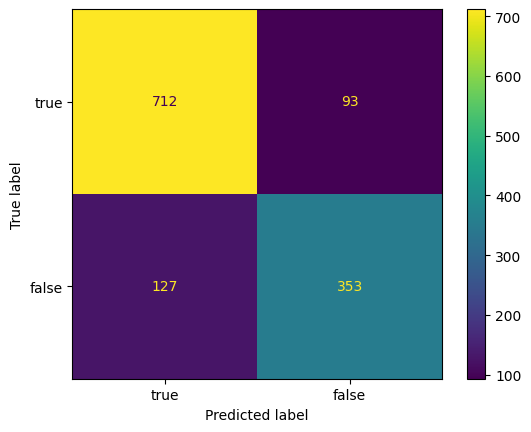

In [53]:
from sklearn.svm import SVC
X_train, X_val, y_train, y_val = train_test_split(pheme.drop('target', axis=1), pheme['target'], train_size=0.8, random_state=42, stratify=pheme['target'])
X_train_text = np.array([text for text in X_train['e_text']])
X_val_text = np.array([text for text in X_val['e_text']])
#baseline = optimize_model("Baseline", X_train_text, y_train)
baseline = SVC(random_state=42)
baseline.fit(X_train_text, y_train)
evaluate_model(baseline, X_val_text, y_val)

Accuracy: 37.56 %
F1: 37.27 %


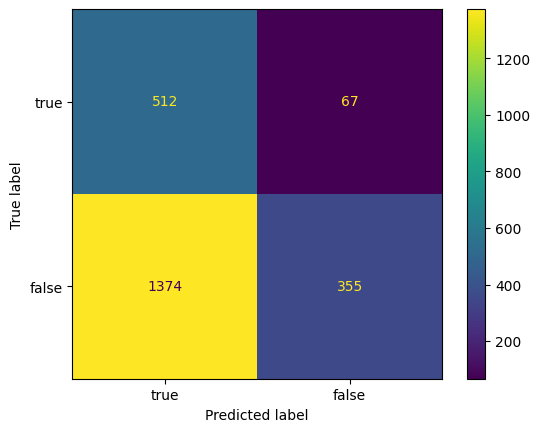

In [52]:
X_test = twitter.drop('target', axis=1)
X_test_text = np.array([text for text in X_test['e_text']])
y_test = twitter['target']
evaluate_model(baseline, X_test_text, y_test)

100%|██████████| 50/50 [00:06<00:00,  6.90s/trial, best loss: 0.35408560311284043]
{'learner': SVC(C=1.2930467747652603, coef0=0.15531204802574028, degree=4, probability=True,
    random_state=42, shrinking=False, tol=0.003788985221333045), 'preprocs': (), 'ex_preprocs': ()}
Accuracy: 52.21 %
F1: 47.32 %


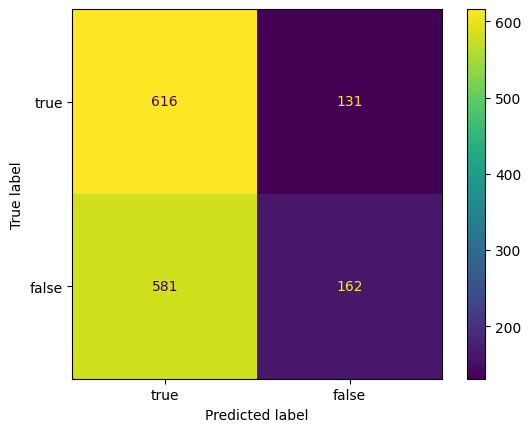

Accuracy: 61.49 %
F1: 57.05 %


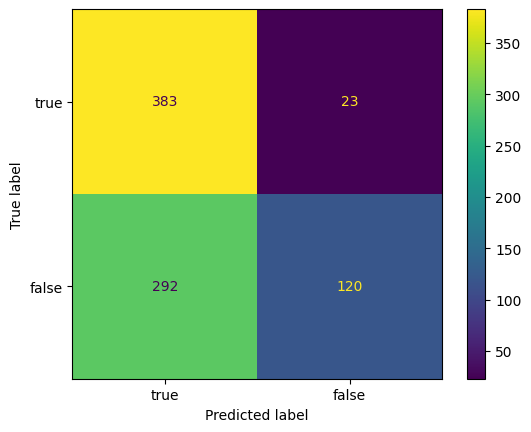

In [109]:
from hpsklearn import svc
from sklearn.model_selection import train_test_split

# Make baseline trained on all data
def make_baseline():
    X_train = pheme.drop('target', axis=1)
    y_train = pheme['target']
    X_train_text = np.array([text for text in X_train['e_text']])
    X_test1 = twitter.iloc[:1490].drop('target', axis=1)
    X_test1_text = np.array([text for text in X_test1['e_text']])
    X_test2 = twitter.iloc[1490:].drop('target', axis=1)
    X_test2_text = np.array([text for text in X_test2['e_text']])
    y_test1 = twitter.iloc[:1490]['target']
    y_test2 = twitter.iloc[1490:]['target']
    baseline = optimize_model("Baseline", X_train_text, y_train)
    evaluate_model(baseline, X_test1_text, y_test1)
    evaluate_model(baseline, X_test2_text, y_test2)

make_baseline()

100%|██████████| 50/50 [00:04<00:00,  4.75s/trial, best loss: 0.18441558441558437]
{'learner': SVC(C=1.7471913774684704, coef0=0.4669858603118654,
    decision_function_shape='ovo', degree=4, probability=True, random_state=42,
    shrinking=False, tol=0.005570264641213312), 'preprocs': (), 'ex_preprocs': ()}
Accuracy: 81.08 %
F1: 80.95 %


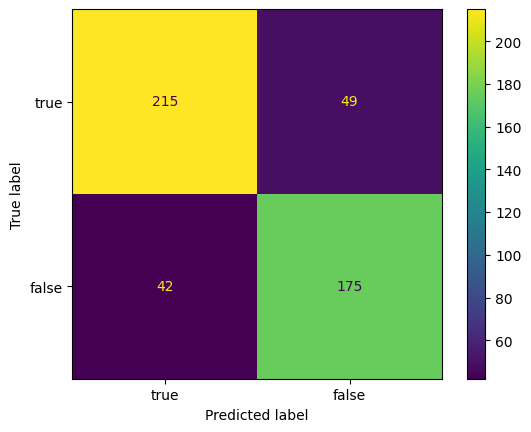

In [ ]:
#ONLY PHEME
from hpsklearn import svc 
from sklearn.model_selection import train_test_split

# Make baseline trained on all data
pheme['e_text'] = X.tolist()
pheme_train = pheme.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(pheme, pheme['target'], test_size = 0.2, random_state = 42)
X_train_text = np.array([text for text in X_train['e_text']])
X_test_text = np.array([text for text in X_test['e_text']])
baseline = optimize_model("Baseline", X_train_text, y_train)
evaluate_model(baseline, X_test_text, y_test)

In [54]:
file_name = "pheme_cats\pheme_categories_organised.json"
f = open(file_name)
data = json.load(f)

In [5]:
#Multiple datasets
confidence_threshold = 0.2
size_threshold = 50
train_set = pheme

def train_svms(dataset, confidence_threshold, size_threshold, train_set):
    file_name = f"{dataset}_cats\\{dataset}_categories_organised.json"
    f = open(file_name)
    data = json.load(f)
    trained_svms = {}
    for key in data.keys():
        svm_name = f"svm_{key}"
        cat_entries = [int(i) for i in data[key].keys() if data[key][i] > confidence_threshold]
        if len(cat_entries) < size_threshold:
            print(f"Skipped category: {key} due to low numbers")
            continue
        all_in_cat = train_set.filter(axis=0, items=cat_entries)
        X_train = all_in_cat.drop('target', axis=1)
        y_train = all_in_cat['target']
        #print(np.unique(all_in_cat["target"]))
        if (len(np.unique(all_in_cat["target"])) <= 1):
            print(f"Skipped category: {key} due to class issues")
            continue
        X_train_text = np.array([text for text in X_train['e_text']])
        try:
            svm_name = optimize_model(svm_name, X_train_text, y_train)
        except:
            print(f"error training {key} svm, skipping")
            continue
        trained_svms[key] = svm_name
        print(f"Created SVM trained in category: {key}")
    return trained_svms

#trained_svms = train_svms("pheme", confidence_threshold, size_threshold)

In [6]:
file_name = "pheme_cats\\pheme_categories_organised.json"
f = open(file_name)
data = json.load(f)

confidence_threshold = 0.2
for key in data.keys():
    entries = [int(i) for i in data[key].keys() if data[key][i] > confidence_threshold]
    all_in_cat = pheme.filter(axis=0, items=entries)
    t = 0
    f=0
    for e in all_in_cat["target"]:
        if e:
            t += 1
        else:
            f += 1
    print(key, len(entries), len(all_in_cat))
    #print(t, f)

Sensitive Subjects/War & Conflict 2432 2432
News 2555 2555
Sensitive Subjects/Death & Tragedy 1326 1326
Sensitive Subjects/Violence & Abuse 2573 2573
Arts & Entertainment 1054 1054
Sensitive Subjects/Other 1208 1208
People & Society 955 955
Law & Government 1325 1325
Online Communities 1111 1111
Books & Literature 30 30
Reference 97 97
Sensitive Subjects/Firearms & Weapons 60 60
Sensitive Subjects/Accidents & Disasters 435 435
Jobs & Education 17 17
Health 81 81
Business & Industrial 38 38
Autos & Vehicles 2 2
Food & Drink 15 15
Travel & Transportation 299 299
Hobbies & Leisure 16 16
Games 0 0
Pets & Animals 7 7
Sports 50 50
Beauty & Fitness 1 1
Science 2 2
Computers & Electronics 10 10
Sensitive Subjects/Recreational Drugs 1 1
Shopping 5 5
Internet & Telecom 3 3
Adult 0 0
Finance 3 3
Sensitive Subjects/Self-Harm 0 0


In [59]:
# ONLY PHEME
from sklearn.model_selection import train_test_split

confidence_threshold = 0.2
size_threshold = 50

X_test = pd.DataFrame(columns = pheme.columns)
y_test = []

trained_svms = {}
trained_cats = []
for key in data.keys():
    svm_name = f"svm_{key}"
    cat_entries = [int(i) for i in data[key].keys() if data[key][i] > confidence_threshold]
    if len(cat_entries) < size_threshold:
        print(f"Skipped category: {key} due to low numbers")
        continue
    all_in_cat = pheme.filter(axis=0, items=cat_entries)
    X_train, X_te, y_train, y_te = train_test_split(all_in_cat, all_in_cat['target'], test_size = 0.2, random_state = 42)
    #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)
    X_test = pd.concat([X_test, X_te])
    for target in y_te:
        y_test.append(target)
    X_train_text = np.array([text for text in X_train['e_text']])
    svm_name = optimize_model(svm_name, X_train_text, y_train)
    trained_svms[key] = svm_name
    trained_cats.append(key)
    print(f"Created SVM trained in category: {key}")

100%|██████████| 5/5 [00:01<00:00,  1.65s/trial, best loss: 0.10526315789473684]
{'learner': SVC(C=0.7878111597060783, coef0=0.23213917415351404,
    decision_function_shape='ovo', degree=1, kernel='linear', probability=True,
    random_state=42, tol=0.004836969013937995), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Law & Government
100%|██████████| 5/5 [00:01<00:00,  1.73s/trial, best loss: 0.1610169491525424]
{'learner': SVC(C=0.8596848116721758, coef0=0.4042616456365805,
    decision_function_shape='ovo', degree=5, gamma='auto', kernel='linear',
    probability=True, random_state=42, tol=2.9029958606502465e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: News
100%|██████████| 5/5 [00:01<00:00,  1.57s/trial, best loss: 0.2666666666666667]
{'learner': SVC(C=0.8302226827564644, coef0=0.5402281088938474,
    decision_function_shape='ovo', kernel='poly', probability=True,
    random_state=42, shrinking=False, tol=4.145267408167087e-05), 'p

In [6]:
def predict_points(trained_svms, test_cats, test_data):
    test_points = test_data
    test_file_name = test_cats
    f = open(test_file_name)
    test_data = json.load(f)
    f.close()
    final_predictions = []
    final_predictions2 = []
    for i in tqdm(range(len(test_points))):
        point = test_points.iloc[i]
        point_text = np.array([text for text in point['e_text']])
        topics = test_data[str(point["entry"])]
        topic_weights = {}
        for topic in topics:
            main_topic = topic.split("/")[1]
            if topics[topic] < confidence_threshold or main_topic not in trained_svms.keys():
                continue
            if main_topic in topic_weights:
                topic_weights[main_topic] += topics[topic]
            else:
                topic_weights[main_topic] = topics[topic]
        #print(topic_weights) 
        model_predictions = []
        for topic in topic_weights:
            model = trained_svms[topic]
            pred = model.predict(point_text.reshape(1,-1))
            #model_predictions.append((pred[0], topic_weights[topic]))
            model_predictions.append((pred[0], 1))
        #print(model_predictions)
        true_mark = 0
        false_mark = 0
        for pred, score in model_predictions:    
            if pred == True:
                true_mark += score
            else:
                false_mark += score
        #print(mark)
        if (true_mark > false_mark):
            final_predictions.append(True)
        else:
            final_predictions.append(False)
        max = 0
        final_pred = True
        for pred, score in model_predictions:
            if score > max:
                final_pred = pred
        final_predictions2.append(final_pred)
    return final_predictions, final_predictions2
             
def check_score(test, pred):
    acc = accuracy_score(test, pred)
    f1 = f1_score(test, pred, average="macro")
    return float("{0:.2f}".format(acc*100)), float("{0:.2f}".format(f1*100))

# Pipeline

In [7]:
def get_results(train_dataset, confidence_threshold, size_threshold, train, tests): 
    X_train, X_val, y_train, y_val = train_test_split(train.drop("target", axis=1), train["target"], train_size=0.8, stratify=train["target"]) 
    train_set = pd.concat([X_train, y_train], axis=1)
    svms = train_svms(train_dataset, confidence_threshold, size_threshold, train_set)

    results = []
    train_cats = f"{train_dataset}_categories.json"
    predictions1, predictions2 = predict_points(svms, train_cats, X_val)
    results.append(check_score(predictions1, y_val))
    
    for test_set, test_cat, test_name in tests:
        test_cat_file = f"{test_cat}_categories.json"
        test_data = test_set.drop("target", axis=1)
        test_target = test_set["target"]
        predictions1, predictions2 = predict_points(svms, test_cat_file, test_data)
        results.append((test_name, check_score(predictions1, test_target)))
    return results

def run_tests(tests, confidence_threshold, size_threshold):
    test_results = []
    for i in tqdm(range(len(tests))):
        t = tests.copy()
        train = t.pop(i)
        test_results.append((train[2], get_results(train[1], confidence_threshold, size_threshold, train[0], t)))
    return test_results

In [8]:
pheme = get_dataset("pheme")
twitter = get_dataset("twitter")
twitter15 = twitter.iloc[:1491]
twitter16 = twitter.iloc[1491:]
tests = [[pheme, "pheme", "PHEME"], [twitter15, "twitter", "twitter15"], [twitter16, "twitter", "twitter16"]]


In [ ]:
tests = [[pheme, "pheme", "PHEME"], [twitter15, "twitter", "twitter15"], [twitter16, "twitter", "twitter16"]]
results1 = run_tests(tests, 0.2, 50)
results2 = run_tests(tests, 0.5, 20)
results3 = run_tests(tests, 0.2, 200)
results4 = run_tests(tests, 0, 100)

  0%|          | 0/3 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:01<?, ?trial/s, best loss=?]
{'learner': SVC(C=1.1046900780257327, coef0=0.7644086587301252, degree=4, probability=True,
    random_state=42, tol=2.3763710716736916e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Sensitive Subjects/War & Conflict
100%|██████████| 8/8 [00:02<00:00,  2.71s/trial, best loss: 0.4142156862745098]


100%|██████████| 10/10 [00:02<00:00,  2.82s/trial, best loss: 0.4142156862745098]


In [14]:
results4

[('PHEME',
  [(76.73, 71.42),
   ('twitter15', (51.51, 43.87)),
   ('twitter16', (54.96, 47.21))]),
 ('twitter15',
  [(70.23, 68.71), ('PHEME', (59.05, 49.53)), ('twitter16', (56.79, 51.14))]),
 ('twitter16',
  [(78.66, 78.3), ('PHEME', (56.81, 55.09)), ('twitter15', (56.07, 53.25))])]

In [12]:
def evaluate_baseline(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    f1_mod = f1_score(y_test, pred_y, average="macro")
    return float("{0:.2f}".format(acc_mod*100)), float("{0:.2f}".format(f1_mod*100))


def run_baseline_tests(tests):
    test_results = []
    for i in tqdm(range(len(tests))):
        t = tests.copy()
        train = t.pop(i)
        test_results.append((train[2], get_baseline_results(train[0], tests)))
    return test_results

def get_baseline_results(train, tests): 
    X_train, X_val, y_train, y_val = train_test_split(train.drop("target", axis=1), train["target"], train_size=0.8, stratify=train["target"]) 
    X_train_text = np.array([text for text in X_train['e_text']])
    X_val_text = np.array([text for text in X_val['e_text']])
    baseline = optimize_model("svm", X_train_text, y_train)
    results = []
    results.append(evaluate_baseline(baseline, X_val_text, y_val))
    for test_set, test_cat, test_name in tests:
        test_data = test_set.drop("target", axis=1)
        test_data_text = np.array([text for text in test_data['e_text']])
        test_target = test_set["target"]
        results.append((test_name, evaluate_baseline(baseline, test_data_text, test_target)))
    return results

baseline_results = run_baseline_tests(tests)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:06<00:00,  6.66s/trial, best loss: 0.15369649805447472]
{'learner': SVC(C=1.2007340688965829, coef0=0.41195154588714744, degree=5, kernel='poly',
    probability=True, random_state=42, tol=0.0021174726338347707), 'preprocs': (), 'ex_preprocs': ()}


 33%|███▎      | 1/3 [03:05<06:11, 185.73s/it]

100%|██████████| 25/25 [00:01<00:00,  1.97s/trial, best loss: 0.20502092050209209]
{'learner': SVC(C=0.5853585639125682, coef0=0.9129795392049047,
    decision_function_shape='ovo', degree=5, kernel='poly', probability=True,
    random_state=42, tol=2.2560165272510383e-05), 'preprocs': (), 'ex_preprocs': ()}


 67%|██████▋   | 2/3 [03:59<01:48, 108.03s/it]

100%|██████████| 25/25 [00:01<00:00,  1.88s/trial, best loss: 0.1984732824427481]
{'learner': SVC(C=0.9906379338992914, coef0=0.5764761568576748, degree=2, kernel='poly',
    probability=True, random_state=42, shrinking=False,
    tol=8.617804258277811e-05), 'preprocs': (), 'ex_preprocs': ()}


100%|██████████| 3/3 [04:46<00:00, 95.48s/it] 


In [13]:
baseline_results

[('PHEME',
  [(83.5, 82.24),
   ('PHEME', (94.09, 93.64)),
   ('twitter15', (50.17, 47.63)),
   ('twitter16', (61.69, 59.78))]),
 ('twitter15',
  [(81.61, 81.6),
   ('PHEME', (55.7, 51.97)),
   ('twitter15', (95.91, 95.91)),
   ('twitter16', (62.3, 60.07))]),
 ('twitter16',
  [(74.39, 74.39),
   ('PHEME', (61.29, 60.87)),
   ('twitter15', (56.2, 55.43)),
   ('twitter16', (87.52, 87.52))])]

In [114]:
test_results = []
result1 = run_test(0.2, 50, "pheme", "twitter")
test_results.append(result1)
result2 = run_test(0.5, 20, "pheme", "twitter")
test_results.append(result2)
result3 = run_test(0.2, 200, "pheme", "twitter")
test_results.append(result3)
result4 = run_test(0, 100, "pheme", "twitter")
test_results.append(result4)

[False  True]
100%|██████████| 50/50 [00:02<00:00,  2.77s/trial, best loss: 0.2813141683778234]
{'learner': SVC(C=0.6513014423079841, coef0=0.221376106013789, kernel='poly',
    probability=True, random_state=42, shrinking=False,
    tol=0.00011969660070096799), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Sensitive Subjects/War & Conflict
[False  True]
100%|██████████| 50/50 [00:03<00:00,  3.06s/trial, best loss: 0.39921722113502933]
{'learner': SVC(C=1.0543080631801196, coef0=0.49084615076292926, degree=5, probability=True,
    random_state=42, shrinking=False, tol=2.3124251746752656e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: News
[False  True]
100%|██████████| 50/50 [00:02<00:00,  2.04s/trial, best loss: 0.27819548872180455]
{'learner': SVC(C=1.3168111038615988, coef0=0.11405124277432921, degree=2, gamma='auto',
    probability=True, random_state=42, shrinking=False,
    tol=0.0001598885178188241), 'preprocs': (), 'ex_preprocs': 

100%|██████████| 2308/2308 [00:01<00:00, 2221.28it/s]


[False  True]
100%|██████████| 50/50 [00:01<00:00,  1.99s/trial, best loss: 0.47619047619047616]
{'learner': SVC(C=1.2856268742727377, coef0=0.023167702769803178, degree=5,
    kernel='sigmoid', probability=True, random_state=42, shrinking=False,
    tol=1.984701739003452e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Sensitive Subjects/War & Conflict
[False  True]
100%|██████████| 50/50 [00:01<00:00,  1.65s/trial, best loss: 0.17808219178082196]
{'learner': SVC(C=0.645173107710793, coef0=0.5991628133297658,
    decision_function_shape='ovo', degree=1, gamma='auto', probability=True,
    random_state=42, tol=2.641275981333177e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: News
[False  True]
100%|██████████| 50/50 [00:01<00:00,  1.65s/trial, best loss: 0.5]
{'learner': SVC(C=1.161749847175693, coef0=0.5498646417638353,
    decision_function_shape='ovo', degree=2, gamma='auto', kernel='linear',
    probability=True, random_state=42, t

100%|██████████| 2308/2308 [00:00<00:00, 3154.39it/s]


[False  True]
100%|██████████| 50/50 [00:02<00:00,  2.43s/trial, best loss: 0.2854209445585215]
{'learner': SVC(C=0.6338939840231934, coef0=0.9021210134862492, kernel='poly',
    probability=True, random_state=42, tol=0.00048198018135909963), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Sensitive Subjects/War & Conflict
[False  True]
100%|██████████| 50/50 [00:02<00:00,  2.73s/trial, best loss: 0.401174168297456]
{'learner': SVC(C=1.1523490477840028, coef0=0.9804616013446563, degree=2, probability=True,
    random_state=42, shrinking=False, tol=0.00656562076745261), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: News
[False  True]
100%|██████████| 50/50 [00:01<00:00,  1.98s/trial, best loss: 0.29323308270676696]
{'learner': SVC(C=1.1433430331127474, coef0=0.8123766690091517, degree=4, gamma='auto',
    probability=True, random_state=42, tol=0.00011191224093271708), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Sensitive 

100%|██████████| 2308/2308 [00:00<00:00, 2464.00it/s]


[False  True]
100%|██████████| 50/50 [00:02<00:00,  2.83s/trial, best loss: 0.2613981762917933]
{'learner': SVC(C=0.8298715294805021, coef0=0.3537008941573464,
    decision_function_shape='ovo', degree=1, kernel='poly', probability=True,
    random_state=42, tol=2.3987987903830595e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Sensitive Subjects/War & Conflict
[False  True]
100%|██████████| 50/50 [00:04<00:00,  4.59s/trial, best loss: 0.40336134453781514]
{'learner': SVC(C=1.1994761989133202, coef0=0.6256175785135298, degree=5, kernel='poly',
    probability=True, random_state=42, tol=1.7817620903384215e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: News
[False  True]
100%|██████████| 50/50 [00:02<00:00,  2.69s/trial, best loss: 0.37083333333333335]
{'learner': SVC(C=1.0262069601155521, coef0=0.9908840317406732,
    decision_function_shape='ovo', degree=1, kernel='poly', probability=True,
    random_state=42, shrinking=False, tol=9.

100%|██████████| 2308/2308 [00:00<00:00, 2458.69it/s]


In [115]:
print(test_results)

[(52.77, 44.99), (51.3, 40.21), (52.64, 44.22), (54.42, 49.6)]
